# Predicting Tour de France Finishing Times with Machine Learning
This is a personal fun-project which I created to learn more about Data Engineering and Cleaning.
A non-perfect Tour de France Dataset, as an interest of mine, was used to practice preparing the data for a Random Forest analysis. 

In [2]:
#import pandas to read in csv
import pandas as pd

#read in tdf_finishers csv as features
df = pd.read_csv('tdf_finishers.csv')
df.head(5)

,Year,Rank,Rider,Time,Team
0,1903,1,Maurice Garin (FRA),"94h 33' 14""",La Française
1,1903,2,Lucien Pothier (FRA),"+ 2h 59' 21""",La Française
2,1903,3,Fernand Augereau (FRA),"+ 4h 29' 24""",La Française
3,1903,4,Rodolfo Muller[27] (ITA),"+ 4h 39' 30""",La Française
4,1903,5,Jean Fischer (FRA),"+ 4h 58' 44""",La Française


In [3]:
# Print first few rows of the Time column to see the exact format
print(df['Time'].head(10))

0      94h 33' 14"
1     + 2h 59' 21"
2     + 4h 29' 24"
3     + 4h 39' 30"
4     + 4h 58' 44"
5     + 5h 52' 24"
6     + 8h 31' 08"
7    + 10h 24' 04"
8    + 10h 52' 14"
9    + 12h 44' 57"
Name: Time, dtype: object


In [4]:
# Function to convert time strings to seconds and determine if it's a difference
def convert_time_to_seconds(time_str):
    if not isinstance(time_str, str) or pd.isna(time_str) or time_str.strip() == "":
        # Return default values if the input is invalid
        return None, False

    # Clean the string
    time_str = time_str.strip()
    is_difference = time_str.startswith('+')
    if is_difference:
        time_str = time_str.replace('+', '').strip()

    total_seconds = 0
    # Handle parts: hours, minutes, seconds
    parts = time_str.split()

    for part in parts:
        if 'h' in part and part.split('h')[0].isdigit():
            hours = int(part.split('h')[0])
            total_seconds += hours * 3600
        elif "'" in part and part.split("'")[0].isdigit():
            minutes = int(part.split("'")[0])
            total_seconds += minutes * 60
        elif '"' in part and part.split('"')[0].isdigit():
            seconds = int(part.split('"')[0])
            total_seconds += seconds

    return total_seconds

#Turns out 2001 to 2005 is missing due to disqualification
#We define the winning time as the one without "+"
def is_first(time_str):
    if not isinstance(time_str, str) or pd.isna(time_str) or time_str.strip() == "":
        # Return default values if the input is invalid
        return None, False

    # Clean the string
    time_str = time_str.strip()
    is_first = not(time_str.startswith('+'))
    return is_first

df["Time_in_seconds"]=df["Time"].apply(convert_time_to_seconds)
df["Winning_Time?"]=df["Time"].apply(is_first)
df.head(5)


,Year,Rank,Rider,Time,Team,Time_in_seconds,Winning_Time?
0,1903,1,Maurice Garin (FRA),"94h 33' 14""",La Française,340394,True
1,1903,2,Lucien Pothier (FRA),"+ 2h 59' 21""",La Française,10761,False
2,1903,3,Fernand Augereau (FRA),"+ 4h 29' 24""",La Française,16164,False
3,1903,4,Rodolfo Muller[27] (ITA),"+ 4h 39' 30""",La Française,16770,False
4,1903,5,Jean Fischer (FRA),"+ 4h 58' 44""",La Française,17924,False


In [5]:
df.columns

Index(['Year', 'Rank', 'Rider', 'Time', 'Team', 'Time_in_seconds',
       'Winning_Time?'],
      dtype='object')

In [6]:
df.dtypes

Year                int64
Rank               object
Rider              object
Time               object
Team               object
Time_in_seconds    object
Winning_Time?      object
dtype: object

In [7]:
#Delete all years prior to 1913, since from 1905 to 1912 the datasets contains no times

df = df[df["Year"]>=1913].copy()

In [8]:
# Convert 'Rank' to integer and 'Time_in_seconds' to numeric (int)
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')
df['Time_in_seconds'] = pd.to_numeric(df['Time_in_seconds'], errors='coerce')

# Create a new column to store updated times
df['Updated_Time_in_seconds'] = df['Time_in_seconds']

# Iterate through each year
for year in df['Year'].unique():
    # Try to get the rank 1 time for this year
    winning_rows = df[(df['Year'] == year) & (df['Winning_Time?'] == True)]
    
    # Check if there are any rows with Rank 1 for this year
    if not winning_rows.empty:
        winning_time = winning_rows['Time_in_seconds'].values[0]
        
        # Add the Rank 1 time to the rows where Rank != 1
        df.loc[(df['Year'] == year) & (df['Winning_Time?'] != True), 'Updated_Time_in_seconds'] += winning_time
    else:
        print(f"No winning time found for Year {year}")

In [9]:
df.head(5)

,Year,Rank,Rider,Time,Team,Time_in_seconds,Winning_Time?,Updated_Time_in_seconds
308,1913,1.0,Philippe Thys (BEL),"197h 54' 00""",Peugeot,712440.0,True,712440.0
309,1913,2.0,Gustave Garrigou (FRA),"+8' 37""",Peugeot,517.0,False,712957.0
310,1913,3.0,Marcel Buysse (BEL),"+ 3h 30' 55""",Peugeot,12655.0,False,725095.0
311,1913,4.0,Firmin Lambot (BEL),"+ 4h 12' 45""",Griffon,15165.0,False,727605.0
312,1913,5.0,François Faber (LUX),"+ 6h 26' 04""",Peugeot,23164.0,False,735604.0


In [10]:
print(df[(df["Winning_Time?"]==True) & (df["Year"]==2009)])

      Year  Rank                   Rider         Time    Team  \
7693  2009   1.0  Alberto Contador (ESP)  85h 48' 35"  Astana   

      Time_in_seconds Winning_Time?  Updated_Time_in_seconds  
7693         308915.0          True                 308915.0  


In [11]:
#To make accurate time predictions, we need to add kilometers driven to our df from another dataset
df_2 = pd.read_csv('tdf_second_dataset_winners.csv')
df_2.head(2)

,edition,start_date,winner_name,winner_team,distance,time_overall,time_margin,stage_wins,stages_led,height,weight,age,born,died,full_name,nickname,birth_town,birth_country,nationality
0,1,1903-07-01,Maurice Garin,La Française,2428.0,94.553889,2.989167,3,6,1.62,60.0,32,1871-03-03,1957-02-19,NaN,The Little Chimney-sweep,Arvier,Italy,France
1,2,1904-07-02,Henri Cornet,Conte,2428.0,96.098611,2.270556,1,3,NaN,NaN,19,1884-08-04,1941-03-18,NaN,Le rigolo (The joker),Desvres,France,France


In [12]:
#Convert string starting dates into numeric year, so we can compare them with the original df
def convert_to_year(time_str):
    if not isinstance(time_str, str) or pd.isna(time_str) or time_str.strip() == "":
        # Return default values if the input is invalid
        return None, False

    # Clean the string
    time_str = time_str.strip()
    year = time_str.split("-")[0]
    return int(year)

df_2["Year"]=df_2["start_date"].apply(convert_to_year)
#df_2["Year"] = pd.to_numeric(df['Year'], errors='coerce')

In [13]:
merged_df = pd.merge(df, df_2[["Year", "distance"]], on = "Year", how="left")

#add missing distances (data only goes up until 2019)
merged_df.loc[merged_df['Year'] == 2020, 'distance'] = 3484.2
merged_df.loc[merged_df['Year'] == 2021, 'distance'] = 3414.4
merged_df.loc[merged_df['Year'] == 2022, 'distance'] = 3349.8
#merged_df = merged_df[merged_df["Year"]<=2019].copy()
merged_df.tail(1)

,Year,Rank,Rider,Time,Team,Time_in_seconds,Winning_Time?,Updated_Time_in_seconds,distance
9586,2022,134.0,Caleb Ewan (AUS),"+ 5h 40' 42""",Lotto–Soudal,20442.0,False,306842.0,3349.8


In [14]:
#Winning Time should be rank 1 (right now, rank of disqualified places is NaN)
#In some cases, this will lead to a shared first place
merged_df.loc[(merged_df['Winning_Time?'] == True), 'Rank'] = 1


#Delete rank cells where NaN or Time_in_seconds where NaN
merged_df = merged_df.dropna(subset=["Rank", "Year", "distance", "Updated_Time_in_seconds"], how="any")

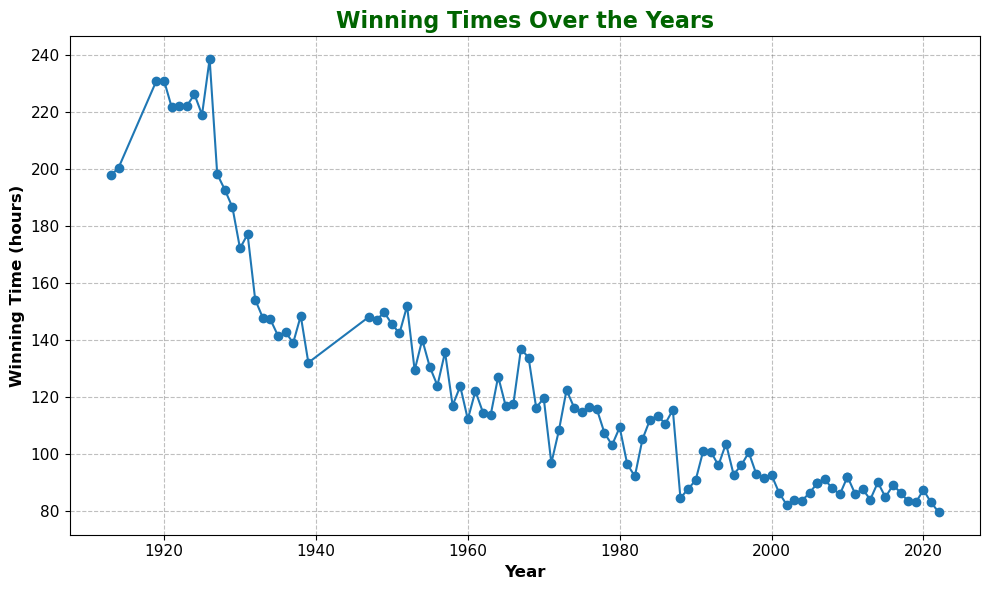

In [15]:
#import matplotlib for plotting an exemplary graph for the winning times over the years
import matplotlib.pyplot as plt

#Create seperate df for rows with winning times only
winning_times_df = merged_df[merged_df["Winning_Time?"]==True].copy()
winning_times_df["Updated_Time_in_hours"]=winning_times_df["Updated_Time_in_seconds"]/60/60

plt.figure(figsize=(10,6))
#Plotting the winning times over time
plt.plot(winning_times_df["Year"], winning_times_df["Updated_Time_in_hours"], marker ="o")

# Adding labels and title
plt.title('Winning Times Over the Years', fontsize=16, fontweight="bold", color="darkgreen")
plt.xlabel('Year', fontweight="bold", fontsize=12)
plt.ylabel('Winning Time (hours)', fontweight="bold", fontsize=12)

#Customize grid and ticks
plt.grid(True, linestyle="--", color="gray", alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

plt.show()

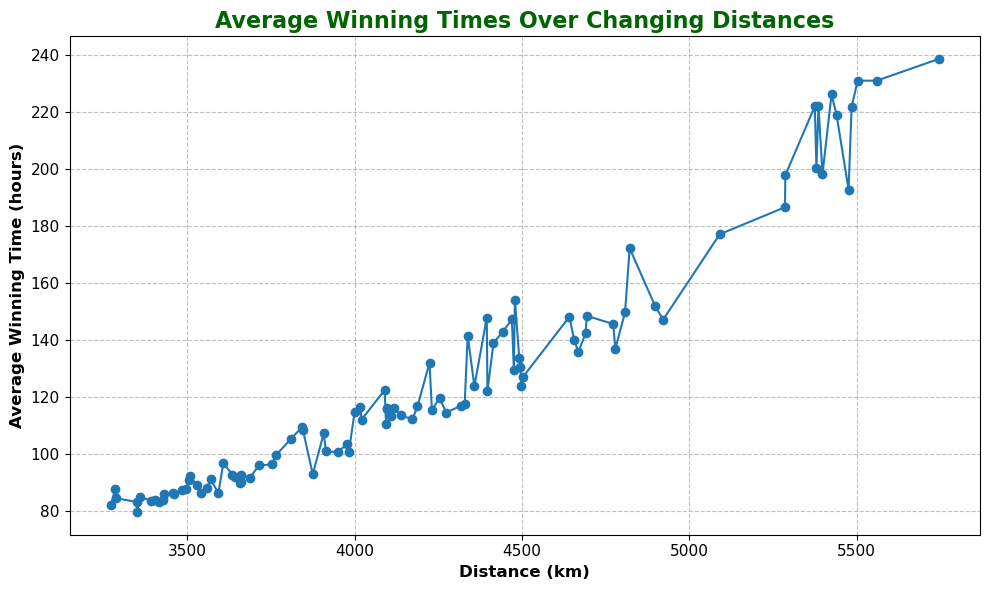

In [16]:
#Graph for the average time based on distance
import matplotlib.pyplot as plt

# Create a separate df for rows with winning times only
winning_times_df = merged_df[merged_df["Winning_Time?"] == True].copy()

#Create seperate df for rows with winning times only
winning_times_df = merged_df[merged_df["Winning_Time?"]==True].copy()
winning_times_df["Updated_Time_in_hours"]=winning_times_df["Updated_Time_in_seconds"]/60/60


# Group by distance and calculate the mean winning time for each distance
avg_times_df = winning_times_df.groupby("distance")["Updated_Time_in_hours"].mean().reset_index()

# Plotting the average winning times over distances
plt.figure(figsize=(10,6))
plt.plot(avg_times_df["distance"], avg_times_df["Updated_Time_in_hours"], marker="o")

# Adding labels and title
plt.title('Average Winning Times Over Changing Distances', fontsize=16, fontweight="bold", color="darkgreen")
plt.xlabel('Distance (km)', fontsize=12, fontweight="bold")
plt.ylabel('Average Winning Time (hours)', fontsize=12, fontweight="bold")

# Customize grid and ticks
plt.grid(True, linestyle="--", color="gray", alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Better Layout
plt.tight_layout()

# Show the graph
plt.show()


# Using Random Forest as an Machine Learning Algorithm
Predicting finishing times based on rank, distance and year. 

In [17]:
import numpy as np

features = merged_df
features.head(3)

,Year,Rank,Rider,Time,Team,Time_in_seconds,Winning_Time?,Updated_Time_in_seconds,distance
0,1913,1.0,Philippe Thys (BEL),"197h 54' 00""",Peugeot,712440.0,True,712440.0,5287.0
1,1913,2.0,Gustave Garrigou (FRA),"+8' 37""",Peugeot,517.0,False,712957.0,5287.0
2,1913,3.0,Marcel Buysse (BEL),"+ 3h 30' 55""",Peugeot,12655.0,False,725095.0,5287.0


In [18]:
#We want to predict the time in seconds
labels=np.array(features["Updated_Time_in_seconds"])


#We want to make the prediction based on the columns "Year", "Rank" and "distance"
features=features[["Year", "Rank", "distance"]]
features.head(3)

,Year,Rank,distance
0,1913,1.0,5287.0
1,1913,2.0,5287.0
2,1913,3.0,5287.0


In [19]:
print("The shape of the features are:", features.shape)

The shape of the features are: (9559, 3)


In [20]:
#Descriptive Statistics of each column
features.describe()

,Year,Rank,distance
count,9559.000000,9559.000000,9559.000000
mean,1984.347526,58.824982,3939.965770
std,27.426017,40.812416,558.137952
min,1913.000000,1.000000,3272.000000
25%,1966.000000,25.000000,3496.000000
50%,1990.000000,51.000000,3765.000000
75%,2007.000000,87.000000,4231.000000
max,2022.000000,174.000000,5745.000000


In [21]:
#saving feature list for future use
feature_list = list(features.columns)

#convert features to numpy array
features = np.array(features)

In [22]:
#use Skikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42) 
print(train_features)

[[1951.    5. 4690.]
 [1990.   58. 3504.]
 [1981.   35. 3753.]
 ...
 [1994.   40. 3978.]
 [1937.   17. 4415.]
 [2008.   45. 3559.]]


In [23]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7169, 3)
Training Labels Shape: (7169,)
Testing Features Shape: (2390, 3)
Testing Labels Shape: (2390,)


In [24]:
#establish a baseline
baseline_preds = np.mean(labels)

#calculate baseline errors and display average baseline error
baseline_errors = (abs(baseline_preds - test_labels))
print("Average baseline error:", round(np.mean(baseline_errors)/60/60, 2), "hours")

Average baseline error: 24.49 hours


In [25]:
#import random forest model from sklean
from sklearn.ensemble import RandomForestRegressor

#instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

#train model on training data
rf.fit(train_features, train_labels)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [26]:
# use the trained model on the test data
predictions = rf.predict(test_features)

#Calculate errors (comparing model and test data)
errors = abs(predictions - test_labels)

#Print mean absolute error
print("Average predicted Error:", round(np.mean(errors)/60,2), "Minutes")
print("Compared to average error from baseline:",round(np.mean(baseline_errors)/60, 2), "Minutes") 

Average predicted Error: 9.48 Minutes
Compared to average error from baseline: 1469.29 Minutes


In [27]:
#Manual Testing: Year, Rank, distance
manual_prediction=rf.predict([[2023, 1, 3540]])[0]
print("Predicted winning time:", round(manual_prediction/60/60,2) ,"hours")

Predicted winning time: 86.76 hours
